In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import time

In [103]:
#load the dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)

In [104]:
batch_size = 64
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

In [105]:
#model
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.embedding = nn.Embedding(10, 10)
        self.sequential = nn.Sequential(
            nn.Linear(150+10, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            #flatten
            nn.Flatten(),
            nn.LazyLinear(out_features=28*28, bias=True),
            nn.Tanh()
        )
    def forward(self, x, label):
        label = self.embedding(label)
        x = torch.cat([x, label], dim=1)
        x = self.sequential(x)
        return x.view(-1, 1, 28, 28)

In [106]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [107]:
z = torch.randn(32, 150).to(device)
label = torch.randint(0, 10, (32,)).to(device)
print(z.shape)
print(label.shape)

torch.Size([32, 150])
torch.Size([32])


In [108]:
G = Generator().to(device)
gen_out = G(z, label)
print(gen_out.shape)

torch.Size([32, 1, 28, 28])


In [109]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.embedding = nn.Embedding(10, 10)
        self.sequential = nn.Sequential(
            nn.Conv2d(1, 32, 3, 1, 1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.MaxPool2d(2, 2),
            #flatten
            nn.Flatten(),
            nn.LazyLinear(out_features=1024, bias=True),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
    def forward(self, x, label):
        x = x.view(-1, 28, 28)
        label = self.embedding(label)
        label = label.unsqueeze(2).repeat(1, 1, 28)
        x = torch.cat([x, label], dim=1)
        x = x.unsqueeze(1)
        #print(x.shape)
        x = self.sequential(x)
        return x       


In [110]:
#feed the output of generator to discriminator
D = Discriminator().to(device)
d_out = D(gen_out, label)
print(d_out.shape)

torch.Size([32, 1])


In [111]:
#loss function
criterion = nn.BCELoss()

#optimizer
lr = 0.0002
beta1 = 0.5
beta2 = 0.999
G_optimizer = optim.Adam(G.parameters(), lr=lr, betas=(beta1, beta2))
D_optimizer = optim.Adam(D.parameters(), lr=lr, betas=(beta1, beta2))

In [118]:
#training loop
num_epochs = 50
for epoch in range(num_epochs):
    for images, labels in trainloader:
        #train discriminator
        D.zero_grad()
        real_images = images.to(device)
        real_labels = labels.to(device)
        real_output = D(real_images, real_labels)
        real_loss = criterion(real_output, torch.ones_like(real_output))
        real_loss.backward()

        noise = torch.randn(64, 150).to(device)
        fake_labels = torch.randint(0, 10, (64,), device=device)
        fake_images = G(noise, fake_labels)
        fake_output = D(fake_images, fake_labels)
        fake_loss = criterion(fake_output, torch.zeros_like(fake_output))
        fake_loss.backward()

        D_optimizer.step()

        #train generator
        G.zero_grad()
        noise = torch.randn(64, 150).to(device)
        fake_labels = torch.randint(0, 10, (64,), device=device)
        fake_images = G(noise, fake_labels)
        fake_output = D(fake_images, fake_labels)
        g_loss = criterion(fake_output, torch.ones_like(fake_output))
        g_loss.backward()
        G_optimizer.step()
        #print loss
        if (epoch + 1) % 2 == 0:
            print('Epoch [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}'
                  .format(epoch + 1, num_epochs, real_loss.item() + fake_loss.item(), g_loss.item()))

Epoch [2/50], d_loss: 0.5833, g_loss: 1.6083
Epoch [2/50], d_loss: 0.6019, g_loss: 2.4063
Epoch [2/50], d_loss: 0.5342, g_loss: 2.3235
Epoch [2/50], d_loss: 0.6808, g_loss: 1.3281
Epoch [2/50], d_loss: 0.7848, g_loss: 1.9622
Epoch [2/50], d_loss: 0.6745, g_loss: 2.2303
Epoch [2/50], d_loss: 0.6556, g_loss: 2.3871
Epoch [2/50], d_loss: 0.4303, g_loss: 2.1758
Epoch [2/50], d_loss: 0.6726, g_loss: 1.5378
Epoch [2/50], d_loss: 0.7075, g_loss: 2.3926
Epoch [2/50], d_loss: 0.8972, g_loss: 1.4827
Epoch [2/50], d_loss: 0.4881, g_loss: 2.1716
Epoch [2/50], d_loss: 0.7068, g_loss: 1.6490
Epoch [2/50], d_loss: 0.6355, g_loss: 2.9516
Epoch [2/50], d_loss: 0.6113, g_loss: 2.1307
Epoch [2/50], d_loss: 0.6229, g_loss: 1.2794
Epoch [2/50], d_loss: 0.9504, g_loss: 3.2542
Epoch [2/50], d_loss: 1.1935, g_loss: 2.4205
Epoch [2/50], d_loss: 0.8161, g_loss: 1.4482
Epoch [2/50], d_loss: 1.2821, g_loss: 2.3519
Epoch [2/50], d_loss: 0.7238, g_loss: 2.3346
Epoch [2/50], d_loss: 0.6059, g_loss: 1.4528
Epoch [2/5

In [121]:
#generate synthetic images
z = torch.randn(64, 150).to(device)
label = torch.randint(0, 1, (64,)).to(device)
fake_images = G(z, label)
fake_images = fake_images.view(-1, 28, 28).detach().cpu().numpy()

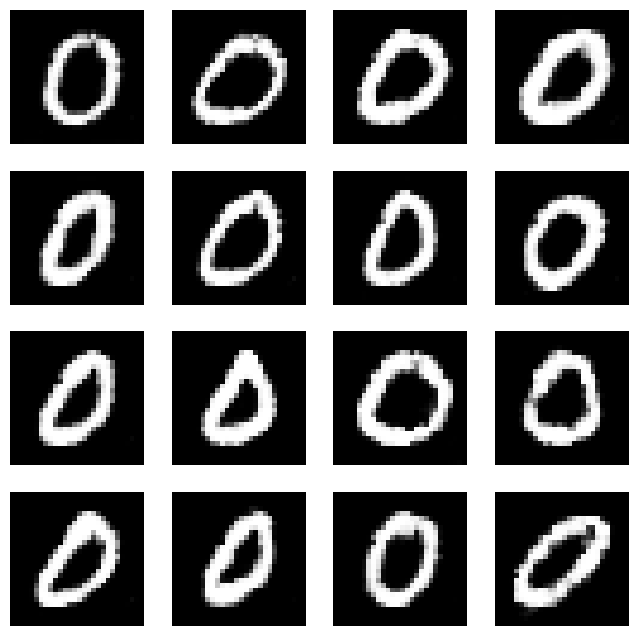

In [122]:
#plot 4x4 grid
import itertools
fig, ax = plt.subplots(4, 4, figsize=(8, 8))
for i, j in itertools.product(range(4), range(4)):
    ax[i, j].imshow(fake_images[i*4+j], cmap='gray')
    ax[i, j].axis('off')
plt.show()

In [123]:
# #save model
# torch.save(G.state_dict(), 'G_conv_mnist.pth')
# torch.save(D.state_dict(), 'D_conv_mnist.pth')